# Heteroskedasticity

In [9]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import os

style.use("fivethirtyeight")

In [10]:
base_url = "https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/"
file = "enem_scores.csv"
enem = pd.read_csv(os.path.join(base_url, file))
enem.head()

,year,school_id,number_of_students,avg_score
0,2007,11000058,144,69.03
1,2006,11000058,184,57.82
2,2005,11000058,220,64.83
3,2006,11000198,51,51.69
4,2005,11000198,47,50.16


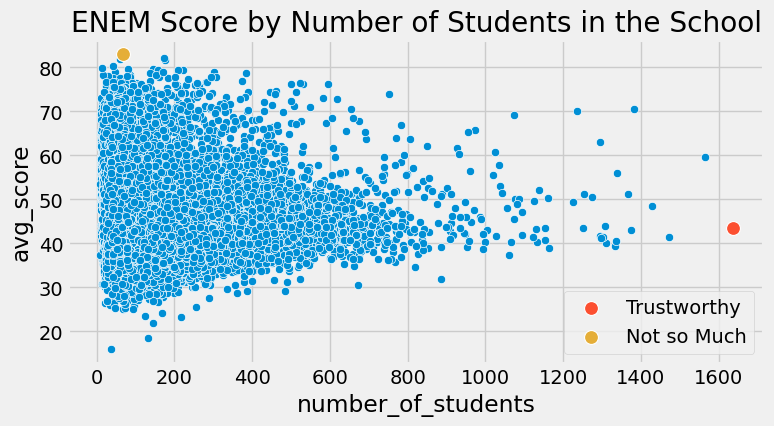

In [7]:
np.random.seed(876)

plt.figure(figsize=(8,4))
sns.scatterplot(y="avg_score", x="number_of_students", data=enem)
sns.scatterplot(y="avg_score", x="number_of_students", s=100, label="Trustworthy",
                data=enem.query(f"number_of_students=={enem.number_of_students.max()}"))
sns.scatterplot(y="avg_score", x="number_of_students", s=100, label="Not so Much",
                data=enem.query(f"avg_score=={enem.avg_score.max()}"))
plt.title("ENEM Score by Number of Students in the School");

As the number of students increases, the __avg_score__ of students becomes more converged, that's called heteroskedasticity, meaning __the variance changes over a variable at different levels__, while homogeneity, meaning the variance stays the same over a variable.

# Weighted Regression

Either regress data points on individual level or on a aggregated level, e.g. regress the avg_score over different schools, it can demonstrate similar results!

In [12]:
file = "wage.csv"
wage = pd.read_csv(os.path.join(base_url, file))[["wage", "lhwage", "educ", "IQ"]]
wage.head()

,wage,lhwage,educ,IQ
0,769,2.956212,12,93
1,808,2.782539,18,119
2,825,3.026504,14,108
3,650,2.788093,12,96
4,562,2.642622,11,74


In [13]:
model_1 = smf.ols('lhwage ~ educ', data=wage).fit()
model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.2954,0.089,25.754,0.000,2.121,2.470
educ,0.0529,0.007,8.107,0.000,0.040,0.066


In [14]:
group_wage = (wage
              .assign(count=1)
              .groupby("educ")
              .agg({"lhwage":"mean", "count":"count"})
              .reset_index())

group_wage

,educ,lhwage,count
0,9,2.856475,10
1,10,2.786911,35
2,11,2.855997,43
3,12,2.922168,393
4,13,3.021182,85
5,14,3.042352,77
6,15,3.090766,45
7,16,3.176184,150
8,17,3.246566,40
9,18,3.144257,57


In [15]:
model_2 = smf.wls('lhwage ~ educ', data=group_wage, weights=group_wage["count"]).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.2954,0.078,29.327,0.000,2.115,2.476
educ,0.0529,0.006,9.231,0.000,0.040,0.066


Look that model_1 and model_2 demonstrate almost exactly the same result, even though `model_2` only regress on 10 data points using __wls__.

The reason behind this is that averages reduce variance. for wls to work it requires,

- responder $y$ needs to use __mean__.
- covariate $X$ needs to use __mean__.

# Heterogeneous

__Heterogeneous__ means that the treatment effect is different on different levels of a variable. Consider the following example, where we want to see how the __education > 12 years__ affects the __hourly wages__.

$$wage = \beta_0 + \beta_1 T + \beta_2 IQ + \beta_3 IQ * T$$

In [24]:
wage = pd.read_csv(os.path.join(base_url, file))\
        .assign(hwage=lambda d: d["wage"] / d["hours"])\
        .assign(T=lambda d: (d["educ"] > 12).astype(int))

wage[["hwage", "IQ", "T"]].head()

,hwage,IQ,T
0,19.225,93,0
1,16.160,119,1
2,20.625,108,1
3,16.250,96,0
4,14.050,74,0


In [26]:
m = smf.ols('hwage ~ T+IQ+T*IQ', data=wage).fit()
m.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.1438,3.002,3.046,0.002,3.253,15.035
T,0.6860,4.791,0.143,0.886,-8.716,10.088
IQ,0.1142,0.031,3.634,0.000,0.053,0.176
T:IQ,0.0242,0.046,0.521,0.602,-0.067,0.115


Let's try to interpret $\beta_3$, when $T=1$, an increase in $IQ$ is

$$E[wage | IQ+1] = \beta_0 + \beta_1 + \beta_2 IQ + \beta_2 + \beta_3 * IQ + \beta_3$$

And

$$E[wage | IQ] = \beta_0 + \beta_1 + \beta_2 IQ + \beta_3 * IQ$$

The extra wage brought by $IQ$ when treated is

$$E[wage | IQ+1, T=1] - E[wage | IQ, T=1] = \beta_2 + \beta_3$$

Similarly, when $T=0$, the extra wage brought by $IQ$ when is not treated is

$$E[wage | IQ+1, T=0] - E[wage | IQ, T=0] = \beta_2$$

Taking the difference of the above, we got the ___extra wage brought by $IQ$ increase for an object when he is treated vs non-treated__, which is __0.024__ in this case.

Suppose a guy has an $IQ = 60$ vs a guy with $IQ=140$, the first guy would get __60 * 0.024 = 1.44__, while the second guy would get __140 * 0.024 = 3.36__ extra wage, if they are treated.

__That means the treatment on different $IQ$ has a different effect on the wage!__

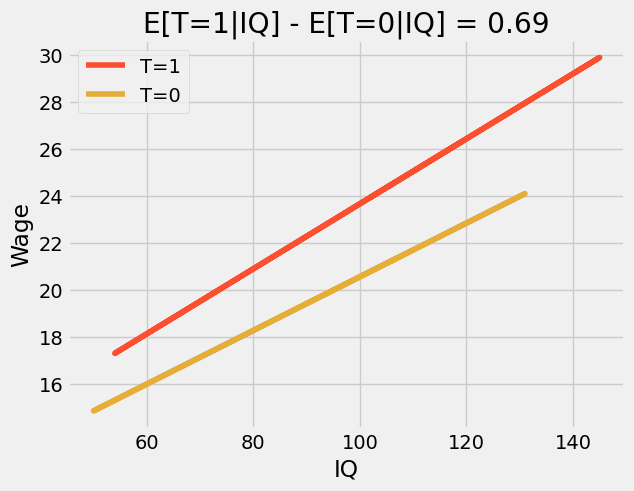

In [28]:
m = smf.ols('hwage ~ T*IQ', data=wage).fit()
plt_df = wage.assign(y_hat = m.fittedvalues)

plt.plot(plt_df.query("T==1")["IQ"], plt_df.query("T==1")["y_hat"], c="C1", label="T=1")
plt.plot(plt_df.query("T==0")["IQ"], plt_df.query("T==0")["y_hat"], c="C2", label="T=0")
plt.title(f"E[T=1|IQ] - E[T=0|IQ] = {round(m.params['T'], 2)}")
plt.ylabel("Wage")
plt.xlabel("IQ")
plt.legend()

# Categorical Regression

If we treat education(ranges from 9 to 18) as categorical, the result:

- $intercept = 18.5$ is the wage when education = 9 years, and all else is set to 0.
- $C(educ)[T.12] = 1.7479$ is the extra wage when education = 12 years __comparing to the baseline__, which is 9 years.

In [29]:
model_dummy = smf.ols('hwage ~ C(educ)', data=wage).fit()
model_dummy.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,18.5600,3.011,6.164,0.000,12.651,24.469
C(educ)[T.10],-0.7874,3.414,-0.231,0.818,-7.488,5.913
C(educ)[T.11],0.1084,3.343,0.032,0.974,-6.452,6.669
C(educ)[T.12],1.7479,3.049,0.573,0.567,-4.236,7.732
C(educ)[T.13],4.3290,3.183,1.360,0.174,-1.918,10.576
C(educ)[T.14],4.0888,3.200,1.278,0.202,-2.192,10.370
C(educ)[T.15],6.3013,3.329,1.893,0.059,-0.231,12.834
C(educ)[T.16],7.2225,3.110,2.323,0.020,1.120,13.325
C(educ)[T.17],9.5905,3.366,2.849,0.004,2.984,16.197
C(educ)[T.18],7.3681,3.264,2.257,0.024,0.962,13.775
